#### *PI7 Part 2*

Onderstaand bevind zich de code over de DNN, om de code te runnen moet eerst de mini_speech_commands dataset folder worden toegevoegd aan de solution file.

### Uitleg van de code

```python
import os
```
Importeer de module `os` om bestands- en padbewerkingen uit te voeren.

```python
import numpy as np
```
Importeer de `numpy` bibliotheek voor numerieke berekeningen en array manipulaties.

```python
import librosa
import librosa.display
```
Importeer `librosa` en de bijbehorende display-module voor audioprocessing en visualisatie.

```python
import matplotlib.pyplot as plt
```
Importeer `matplotlib.pyplot` voor het maken van grafieken en visualisaties.

```python
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import recall_score
```
Importeer functies van `sklearn` voor dataverwerking en evaluatie, zoals het splitsen van datasets, label-encoding en het berekenen van recall.

```python
import torch
import torch.nn as nn
```
Importeer de `torch` bibliotheek en de submodule `nn` voor het bouwen van neurale netwerken.

```python
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
```
Importeer DataLoader en Dataset om data in batches te laden en optimalisatie-algoritmen voor modeltraining.

In [7]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import recall_score
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

```python
data_dir = './mini_speech_commands'
```
Definieer de variabele `data_dir` die het pad naar de dataset directory bevat.

In [8]:
data_dir = './mini_speech_commands'

```python
def extract_mfcc(file_path, max_pad_len=44):
```
Definieer de functie `extract_mfcc` die de MFCC (Mel-frequency cepstral coefficients) features uit een audiobestand extraheert.

```python
audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
```
Laad het audiobestand met `librosa` en verkijg het bijbehorende sample rate.

```python
mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
```
Extraheer de MFCC-functies uit de audio met 40 coefficients.

```python
mfcc = librosa.util.normalize(mfcc)
```
Normaliseer de MFCC om de waarden tussen 0 en 1 te brengen.

```python
pad_width = max_pad_len - mfcc.shape[1]
mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
```
Bepaal de padding die nodig is om de MFCC-array naar een maximale breedte te brengen en pas deze padding toe.

```python
return mfcc
```
Geef de geëxtraheerde en genormaliseerde MFCC terug.

In [9]:
def extract_mfcc(file_path, max_pad_len=44):
    try:
        audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast') 
        mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfcc = librosa.util.normalize(mfcc)
        pad_width = max_pad_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
        return mfcc
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

```python
commands = ['yes', 'no', 'up', 'down', 'left', 'right', 'go', 'stop']
X = []
y = []
```
Definieer een lijst van spraakcommando's en maak lege lijsten voor de inputfeatures (`X`) en labels (`y`).

In [10]:
commands = ['yes', 'no', 'up', 'down', 'left', 'right', 'go', 'stop']
X = []
y = []

```python
for label in commands:
    label_dir = os.path.join(data_dir, label)
```
Loop over elke command en bouw het pad naar de directory van die command.

```python
for file_name in os.listdir(label_dir):
    file_path = os.path.join(label_dir, file_name)
```
Voor elk audiobestand in de directory, krijg het volledige pad naar het bestand.

```python
mfcc = extract_mfcc(file_path)
```
Roep de functie `extract_mfcc` aan om de MFCC van het huidige audiobestand te extraheren.

```python
if mfcc is not None:
    X.append(mfcc)
    y.append(label)
```
Als de MFCC succesvol is geëxtraheerd, voeg deze dan toe aan de lijst `X` en de bijbehorende label aan de lijst `y`.

In [11]:
for label in commands:
    label_dir = os.path.join(data_dir, label)
    for file_name in os.listdir(label_dir):
        file_path = os.path.join(label_dir, file_name)
        mfcc = extract_mfcc(file_path)
        if mfcc is not None:
            X.append(mfcc)
            y.append(label)

```python
X = np.array(X)
y = np.array(y)
```
Converteer de lijsten `X` en `y` naar NumPy-arrays.

In [12]:
X = np.array(X)
y = np.array(y)

```python
le = LabelEncoder()
y_encoded = le.fit_transform(y)
```
Initialiseer een `LabelEncoder` en encodeer de labels naar integers.

In [13]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

```python
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
```
Splits de dataset in training en test sets met een ratio van 80-20.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

```python
class SpeechDataset(Dataset):
```
Definieer een custom Dataset-klasse `SpeechDataset` die de PyTorch `Dataset` uitbreidt.

```python
def __init__(self, X, y):
    self.X = X
    self.y = y
```
Initialiseer de klasse met de inputfeatures (`X`) en labels (`y`).

```python
def __len__(self):
    return len(self.X)
```
Definieer de methode `__len__` die de lengte van de dataset retourneert.

```python
def __getitem__(self, idx):
    return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.long)
```
Definieer de methode `__getitem__` die een sample uit de dataset retourneert als PyTorch-tensors.

In [15]:
class SpeechDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.long)

```python
train_dataset = SpeechDataset(X_train, y_train)
test_dataset = SpeechDataset(X_test, y_test)
```
Maak instanties van `SpeechDataset` voor zowel de trainings- als testdatasets.

In [16]:
train_dataset = SpeechDataset(X_train, y_train)
test_dataset = SpeechDataset(X_test, y_test)

```python
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
```
Creëer `DataLoader`-objecten voor batchgewijze toegang tot de trainings- en testdatasets.

In [17]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

```python
class CNN_LSTM(nn.Module):
```
Definieer een CNN-LSTM modelklasse die de PyTorch `nn.Module` uitbreidt.

```python
def __init__(self, num_classes):
```
Initialiseer het model met het aantal klassen als parameter.

```python
self.cnn = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2)
)
```
Definieer de CNN-sequentie bestaande uit convolutielagen, activatiefuncties en max pooling.

```python
self.dropout = nn.Dropout(0.3)
```
Voeg een dropout-laag toe na de CNN om overfitting te voorkomen.

```python
self.lstm = nn.LSTM(32 * 10, 64, batch_first=True)
self.fc = nn.Linear(64, num_classes)
```
Definieer de LSTM-laag en de volledig verbonden laag die de output aan het aantal klassen verbindt.

```python
def forward(self, x):
```
Definieer de `forward` methode die de input door het netwerk leidt.

```python
x = self.cnn(x.unsqueeze(1)) 
```
Voeg een kanaaldimensie toe aan de input en pas de CNN toe.

```python
x = self.dropout(x) 
```
Pas dropout toe op de output van de CNN.

```python
x = x.view(x.size(0), -1, 32 * 10) 
```
Herschik de tensor voor input in de LSTM.

```python
x, _ = self.lstm(x)
```
Voer de LSTM uit op de input.

```python
x = x[:, -1, :] 
```
Selecteer de laatste output van de LSTM.

```python
x = self.fc(x)
return x
```
Voer de output door de volledig verbonden laag en geef de output terug.

In [18]:
class CNN_LSTM(nn.Module):
    def __init__(self, num_classes):
        super(CNN_LSTM, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.dropout = nn.Dropout(0.3)
        self.lstm = nn.LSTM(32 * 10, 64, batch_first=True)
        self.fc = nn.Linear(64, num_classes)
    
    def forward(self, x):
        x = self.cnn(x.unsqueeze(1))  
        x = self.dropout(x) 
        x = x.view(x.size(0), -1, 32 * 10) 
        x, _ = self.lstm(x)
        x = x[:, -1, :] 
        x = self.fc(x)
        return x

```python
num_classes = len(commands)
learning_rate = 0.001
num_epochs = 5
```
Definieer hyperparameters zoals het aantal klassen, leersnelheid en aantal epochs.

In [19]:
num_classes = len(commands)
learning_rate = 0.001
num_epochs = 50

```python
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
```
Controleer of een GPU beschikbaar is en stel het apparaat in op `cuda` of `cpu`.

```python
model = CNN_LSTM(num_classes).to(device)
```
Creëer een instantie van het model en verplaats deze naar het juiste apparaat.

```python
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
```
Definieer de verliesfunctie en de optimizer voor het model.

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN_LSTM(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

```python
train_history = []
val_history = []
```
Initialiseer lijsten om de trainings- en validatiegeschiedenis op te slaan.

In [21]:
train_history = []
val_history = []

```python
for epoch in range(num_epochs):
```
Begin een loop voor het aantal epochs.

```python
model.train()
running_loss = 0.0
```
Zet het model in de trainingsmodus en initialiseer de lopende verlieswaarde.

```python
for mfccs, labels in train_loader:
```
Loop over batches in de `train_loader`.

```python
mfccs, labels = mfccs.to(device), labels.to(device)
```
Verplaats de MFCCs en labels naar het juiste apparaat.

```python
outputs =

 model(mfccs)
loss = criterion(outputs, labels)
```
Voer een forward pass uit en bereken het verlies.

```python
optimizer.zero_grad()
loss.backward()
optimizer.step()
```
Voer de backward pass uit en update de gewichten van het model.

```python
running_loss += loss.item()
```
Voeg het verlies van de huidige batch toe aan de lopende verlieswaarde.

```python
train_history.append(running_loss / len(train_loader))
```
Bereken het gemiddelde verlies voor de training en sla het op.

```python
model.eval()
val_loss = 0.0
```
Zet het model in evaluatiemodus en initialiseer de validatieverlieswaarde.

```python
with torch.no_grad():
```
Deactiveer gradient tracking om geheugengebruik te besparen tijdens evaluatie.

```python
for mfccs, labels in test_loader:
```
Loop over batches in de `test_loader`.

```python
mfccs, labels = mfccs.to(device), labels.to(device)
outputs = model(mfccs)
loss = criterion(outputs, labels)
```
Voer een forward pass uit en bereken het verlies op de testdata.

```python
val_loss += loss.item()
```
Voeg het verlies van de huidige batch toe aan de validatieverlieswaarde.

```python
val_history.append(val_loss / len(test_loader))
```
Sla het gemiddelde verlies voor de validatie op.

```python
print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_history[-1]:.4f}, Val Loss: {val_history[-1]:.4f}")
```
Print de verlieswaarden voor de huidige epoch.

In [22]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for mfccs, labels in train_loader:
        mfccs, labels = mfccs.to(device), labels.to(device)

        outputs = model(mfccs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_history.append(running_loss / len(train_loader))


    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for mfccs, labels in test_loader:
            mfccs, labels = mfccs.to(device), labels.to(device)
            outputs = model(mfccs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_history.append(val_loss / len(test_loader))

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_history[-1]:.4f}, Val Loss: {val_history[-1]:.4f}")

Epoch [1/50], Train Loss: 2.0791, Val Loss: 2.0751
Epoch [2/50], Train Loss: 1.9854, Val Loss: 1.8223
Epoch [3/50], Train Loss: 1.7259, Val Loss: 1.5490
Epoch [4/50], Train Loss: 1.4795, Val Loss: 1.2923
Epoch [5/50], Train Loss: 1.2989, Val Loss: 1.1450
Epoch [6/50], Train Loss: 1.2035, Val Loss: 1.0769
Epoch [7/50], Train Loss: 1.1087, Val Loss: 1.0075
Epoch [8/50], Train Loss: 1.0440, Val Loss: 0.9464
Epoch [9/50], Train Loss: 0.9760, Val Loss: 0.9796
Epoch [10/50], Train Loss: 0.9311, Val Loss: 0.8572
Epoch [11/50], Train Loss: 0.8910, Val Loss: 0.8231
Epoch [12/50], Train Loss: 0.8630, Val Loss: 0.8075
Epoch [13/50], Train Loss: 0.8193, Val Loss: 0.7518
Epoch [14/50], Train Loss: 0.7945, Val Loss: 0.7611
Epoch [15/50], Train Loss: 0.7752, Val Loss: 0.7144
Epoch [16/50], Train Loss: 0.7436, Val Loss: 0.6967
Epoch [17/50], Train Loss: 0.7239, Val Loss: 0.6929
Epoch [18/50], Train Loss: 0.7131, Val Loss: 0.6832
Epoch [19/50], Train Loss: 0.6682, Val Loss: 0.6576
Epoch [20/50], Train 

-----------------------------------------------------------------------------------------------------------------------------------------------

```python
plt.plot(train_history, label='train')
plt.plot(val_history, label='val')
```
Plot de trainings- en validatieverliezen.

```python
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
```
Voeg titels, labels en legenda toe aan de plot en toon deze.

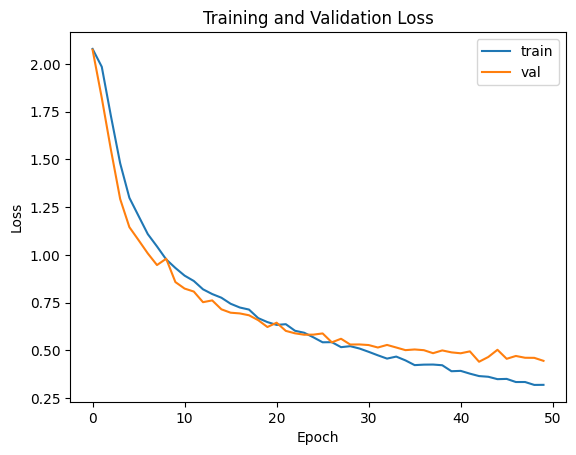

In [23]:
plt.plot(train_history, label='train')
plt.plot(val_history, label='val')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

-----------------------------------------------------------------------------------------------------------------------------------------------

```python
model.eval()
test_loss = 0.0
correct = 0
total = 0
all_labels = []
all_predictions = []
```
Zet het model in evaluatiemodus en initialiseer variabelen voor testevaluatie.

In [24]:
model.eval()
test_loss = 0.0
correct = 0
total = 0
all_labels = []
all_predictions = []

```python
with torch.no_grad():
```
Deactiveer gradient tracking voor de evaluatie.

```python
for mfccs, labels in test_loader:
```
Loop over batches in de `test_loader`.

```python
mfccs, labels = mfccs.to(device), labels.to(device)
outputs = model(mfccs)
loss = criterion(outputs, labels)
test_loss += loss.item()
```
Voer een forward pass uit, bereken het verlies en voeg dit toe aan de testverlieswaarde.

```python
_, predicted = torch.max(outputs.data, 1)
```
Bepaal de voorspellingen door de maximale outputwaarde van het model te nemen.

```python
total += labels.size(0)
correct += (predicted == labels).sum().item()
```
Tel het totaal aantal correct geclassificeerde labels.

```python
all_labels.extend(labels.cpu().numpy())
all_predictions.extend(predicted.cpu().numpy())
```
Verzamel alle labels en voorspellingen voor evaluatie.

In [25]:
with torch.no_grad():
    for mfccs, labels in test_loader:
        mfccs, labels = mfccs.to(device), labels.to(device)
        outputs = model(mfccs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

```python
test_loss /= len(test_loader)
accuracy = 100 * correct / total
```
Bereken het gemiddelde testverlies en de nauwkeurigheid van het model.

In [26]:
test_loss /= len(test_loader)
accuracy = 100 * correct / total

```python
recall = recall_score(all_labels, all_predictions, average='macro')
```
Bereken de recall score voor de testset.

```python
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%')
print(f'Test Recall: {recall:.4f}')
```
Print de uiteindelijke testverlies, nauwkeurigheid en recall scores.

In [27]:
recall = recall_score(all_labels, all_predictions, average='macro')

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%')
print(f'Test Recall: {recall:.4f}')

Test Loss: 0.4444, Test Accuracy: 85.19%
Test Recall: 0.8547
